In [1]:
#%%capture
#!pip install torch==2.0.0 torchvision==0.15.1
#!pip install d2l==1.0.3


# d2l - Chapter 11

## Section 11.3 - Attention Scoring Functions

In [2]:
import torch
from torch import nn
from d2l import torch as d2l


In [3]:
# BMM
minibatch_size = 5
Q = torch.ones(minibatch_size, 3, 4)
K = torch.ones(minibatch_size, 4, 2)

QM = torch.bmm(Q, K)

d2l.check_shape(QM, (minibatch_size, 3, 2))


In [4]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1) 




In [5]:
# Scaled dot product attention
import math 
class DotProductAttention(nn.Module):
    
    def __init__(self, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens=None):
        # Shape of queries: (batch_size, no. of queries, d)
        # Shape of keys: (batch_size, no. of key-value pairs, d)
        # Shape of values: (batch_size, no. of key-value pairs, value dimension)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        
        print(f'  DotProductAttention scores shape: {scores.shape}  # minibatch_size, n_queries, n_key_value_pairs')
        
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [6]:
minibatch_size = 6
dim_q = 2
dim_k = 2
dim_v = 4
n_key_value_pairs = 10
n_queries = 5

# Note: We use a normal with mean 0 and standard deviation 1 to initialize the queries, keys, and values.
queries = torch.normal(0, 1, (minibatch_size, n_queries, dim_q))
keys = torch.normal(0, 1, (minibatch_size, n_key_value_pairs, dim_k))
values = torch.normal(0, 1, (minibatch_size, n_key_value_pairs, dim_v))
valid_lens = torch.tensor([2, 6, 3, 4, 5, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (minibatch_size, n_queries, dim_v))


  DotProductAttention scores shape: torch.Size([6, 5, 10])  # minibatch_size, n_queries, n_key_value_pairs


## Section 11.4

In [7]:
import torch
from torch import nn
from d2l import torch as d2l


In [8]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);


In [9]:
# Defining the decoder with attention
class Decoder(nn.Module):  #@save
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # We add an additional init_state method to convert the encoder output (enc_all_outputs) 
    # into the encoded state. 
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError


In [10]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class AdditiveAttention(nn.Module):
    
    def __init__(self, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)

        # Why no bias term(s)?
        # The primary role of the attention score is to _measure the relative similarity_ between the query and each key. A bias term 
        # adds a constant shift to the score, which generally affects the absolute magnitude but may not drastically alter the 
        # final $\text{Softmax}$ distribution, as $\text{Softmax}$ is a relative function.By omitting bias, the model is forced to rely 
        # purely on the interaction and transformation of the $\mathbf{q}$ and $\mathbf{k}$ vectors to determine the score, making the 
        # function more directly focused on the alignment relationship.

        # in_features is inferred
        self.W_k = nn.LazyLinear(out_features=num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)

        # w_v is used to map to a scalar as $\alpha \in R^{+}$.
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    # valid_lens: The parameter valid_lens is a tensor used in sequence modeling (like RNNs or Transformers) to handle mini-batches containing 
    # sequences of different lengths that have been padded.
    # Its primary purpose is to tell the model exactly which parts of the input are real data and which parts are padding, 
    # ensuring calculations like attention and loss are only performed on the valid, non-padding elements.
    # See, for exampled, masked attention.    
    def forward(self, queries, keys, values, valid_lens):
        # queries.shape = (batch_size, sequence length, feature dimension)
        # The feature length (or feature dimension) of the input tensors like queries, keys, and values is 
        # greater than 1 because each token (word) in the sequence is represented by a high-dimensional vector, known as an embedding.
        queries, keys = self.W_q(queries), self.W_k(keys)                

        # NOTE: We want learnable parameters for both the query and the key!
        # The .unsqueeze(index) operation in PyTorch inserts a new dimension of size 1 into a tensor at the specified index.
        # (B, T_q, H) + (B, T_k, H)  => (B, T_q, 1, H) + (B, 1, T_k, H) == [broadcasting] => (B, T_q, T_k, H)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        
        
        scores = self.w_v(features).squeeze(-1)

        self.attention_weights = masked_softmax(scores, valid_lens)        

        # Performs a batch matrix-matrix product of matrices (11.3.2.2)
        V = values
        Q = queries
        K = keys
        
        print(f'  AdditiveAttention: W_q.shape = {self.W_q}')
        print(f'  AdditiveAttention: Q.shape   = {Q.shape}')
        print(f'  AdditiveAttention: W_k.shape = {self.W_k}')
        print(f'  AdditiveAttention: K.shape   = {K.shape}')
        
        print(f'  AdditiveAttention: queries.unsqueeze(2).shape = {queries.unsqueeze(2).shape}')
        print(f'  AdditiveAttention: keys.unsqueeze(1).shape    = {keys.unsqueeze(1).shape}')
        
        print(f'  AdditiveAttention: W_v.shape = {self.w_v}')
        print(f'  AdditiveAttention: V.shape   = {V.shape}')
        
        print(f'  AdditiveAttention: features.shape = {features.shape}')
        print(f'  AdditiveAttention: weights.shape = {self.attention_weights.shape}')
        
        return torch.bmm(self.dropout(self.attention_weights), V)


    

shape       = [minibatch_size, seq_len, dim]
Q_org.shape = torch.Size([3, 1, 20])
K_org.shape = torch.Size([3, 10, 5])
V_org-shape = torch.Size([3, 10, 4])
  AdditiveAttention: W_q.shape = Linear(in_features=20, out_features=8, bias=False)
  AdditiveAttention: Q.shape   = torch.Size([3, 1, 8])
  AdditiveAttention: W_k.shape = Linear(in_features=5, out_features=8, bias=False)
  AdditiveAttention: K.shape   = torch.Size([3, 10, 8])
  AdditiveAttention: queries.unsqueeze(2).shape = torch.Size([3, 1, 1, 8])
  AdditiveAttention: keys.unsqueeze(1).shape    = torch.Size([3, 1, 10, 8])
  AdditiveAttention: W_v.shape = Linear(in_features=8, out_features=1, bias=False)
  AdditiveAttention: V.shape   = torch.Size([3, 10, 4])
  AdditiveAttention: features.shape = torch.Size([3, 1, 10, 8])
  AdditiveAttention: weights.shape = torch.Size([3, 1, 10])
Shape of attention output: torch.Size([3, 1, 4])
  AdditiveAttention: W_q.shape = Linear(in_features=20, out_features=8, bias=False)
  AdditiveAttention

/home/calvin/.venvs/venv_d2l/lib64/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


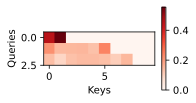

In [11]:
# Section 1.1.1: Understand shapes of queries, keys, and values in attention mechanisms

minibatch_size = 3

seq_len_queries = 1
seq_len_keys = 10
seq_len_values = 10

dim_queries = 20  # Dimentionality of the queries
dim_values = 4  # Dimentionality of the values
dim_keys = 5  # Dimentionality of the keys

# NOTE: We use normal distribution to initialize the queries, keys, and values
queries = torch.normal(0, 1, (minibatch_size, seq_len_queries, dim_queries))
keys    = torch.normal(0, 1, (minibatch_size, seq_len_keys, dim_keys))
values  = torch.normal(0, 1, (minibatch_size, seq_len_values, dim_values))

print(f'shape       = [minibatch_size, seq_len, dim]')
print(f'Q_org.shape = {queries.shape}')
print(f'K_org.shape = {keys.shape}')
print(f'V_org-shape = {values.shape}')

# Length per observation is 2 and 6
valid_lens = torch.tensor([2, 6, 8])

# 
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
attention_weights = attention(queries, keys, values, valid_lens)
print('Shape of attention output:', attention_weights.shape)

d2l.check_shape(attention(queries, keys, values, valid_lens), (minibatch_size, 1, dim_values))

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 3, 10)), xlabel='Keys', ylabel='Queries')


In [12]:
class Seq2SeqAttentionDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()

        # num_hidden layers in W_k and W_q
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.GRU(
            # We use as input to the GRU the h_T (dim = num_hiddens) and y_t (dim = embed_size)
            input_size=embed_size + num_hiddens,
            hidden_size=num_hiddens,
            num_layers=num_layers,
            dropout=dropout
        )
        
        # W_{vocab} - Used to predict the next token
        #  The simplest example is: P(y_t | ... ) = softmax[ W_{vocab} \cdot s_t ], where 
        #  s_t = f(s_{t-1}, y_{t-1}, c_{t-1}) is the decoder state at time t.
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.apply(d2l.init_seq2seq)
        
        
    def init_state(self, enc_outputs, enc_valid_lens):
        # enc_outputs = [outputs, state], where:
        #   1) outputs: all the hidden states _of the last layer_ of the encoder 
        #   2) state: the final hidden state of the encoder (includes all layers)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs        
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):        
        # For testing, we create X = torch.zeros((batch_size, num_steps), dtype=torch.long)
    
        enc_outputs, hidden_state, enc_valid_lens = state
        
        # Y: The target sequence (so far: eval; full: testing))
        X = self.embedding(X).permute(1, 0, 2)
        
        dec_outputs = []  # The topmost layer of the RNN: add iteratively after each loop through the RNN
        self._attention_weights = []  # Store \alpha_t iteratively after each loop through the RNN
        
        
        # Iterate over first dimension:
        # X.shape = (num_steps, batch_size, embed_size)
        for y_t in X:
            
            # hidden_state.shape = (num_layers, batch_size, num_hiddens)
            query = hidden_state[-1]  # s_{t-1}: The final hidden state of the encoder (includes all layers)
            query = query.unsqueeze(dim=1)  # (batch_size, 1, num_hiddens)
            
            # Context: c_{t-1}
            #   + Code: torch.bmm(self.dropout(self.attention_weights), V)
            #   + Formula: c_{t-1} = \sum_{i=1}^{T_y} \alpha_{q, k_i} v_i
            #   + Parameters for forward: queries, keys, values, valid_lens
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            
            # s_t = f(s_{t-1}, y_{t-1}, c_{t-1})
            #     = RNN( [y_{t-1}, c_{t-1}] , s_{t-1} )
            # Shape y_t = (batch_size, embed_size) => unsqueeze to (batch_size, 1, num_hiddens)
            # Shape context = (batch_size, 1, num_hiddens) 
            # dim=-1: concat along the last dimension
            y_t = torch.cat((context, y_t.unsqueeze(1)), dim=-1)
        
            # Pass through RNN
            # y_t shape: (batch_size, 1, embed_size + num_hidden)
            # Input shape RNN: seq_len, batch_size, input_size
            #   out: Remember: we go through the sequence one step at a time!
            #        out = topmost layer of RNN at time step t
            out, hidden_state = self.rnn(y_t.permute(1, 0, 2), hidden_state)
            dec_outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
            
        # Create outputs that contain all topmost layers of the RNN
        dec_outputs = self.dense(torch.cat(dec_outputs, dim=0))
        return dec_outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
        
    @property
    def attention_weights(self):
        return self._attention_weights  # Defined in forward function
        

In [13]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))


#### Training

In [14]:
class MTFraEng(d2l.DataModule):
    """The English-French dataset.

    Defined in :numref:`sec_machine_translation`"""
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, text):
        """Defined in :numref:`sec_machine_translation`"""
        # Replace non-breaking space with space
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
               for i, char in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        """Defined in :numref:`sec_machine_translation`"""
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # Skip empty tokens
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt

    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128, root='./data'):
        """Defined in :numref:`sec_machine_translation`"""
        super(MTFraEng, self).__init__(root=root)
        self.save_hyperparameters()
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._download())

    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        """Defined in :numref:`subsec_loading-seq-fixed-len`"""
        def _build_array(sentences, vocab, is_tgt=False):
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = d2l.Vocab(sentences, min_freq=2)
            array = d2l.tensor([vocab[s] for s in sentences])
            valid_len = d2l.reduce_sum(
                d2l.astype(array != vocab['<pad>'], d2l.int32), 1)
            return array, vocab, valid_len
        src, tgt = self._tokenize(self._preprocess(raw_text),
                                  self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)

    def get_dataloader(self, train):
        """Defined in :numref:`subsec_loading-seq-fixed-len`"""
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)


    def build(self, src_sentences, tgt_sentences):
        """Defined in :numref:`subsec_loading-seq-fixed-len`"""
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
            src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(
            raw_text, self.src_vocab, self.tgt_vocab)
        return arrays


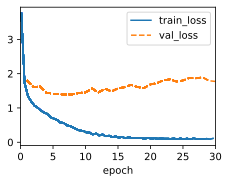

In [15]:
data = MTFraEng(batch_size=128, root='./data')
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2

encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


#### Prediction

In [16]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


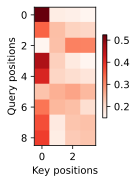

In [17]:
_, dec_attention_weights = model.predict_step(data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)

attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions'
)


## Section 11.5

In [18]:
class MultiHeadAttention(nn.Module):
    
    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""        
        
        # This line splits the last dimension (num_hiddens) into num_heads. The -1 automatically calculates the correct 
        # size for the last dimension, which is num_hiddens / num_heads.
        # (batch_size, seq_len, num_hiddens) → (batch_size, seq_len, num_heads, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        
        # This is the key step for parallelization. It swaps the seq_len (axis 1) and num_heads (axis 2) dimensions.
        # Purpose: To group all the heads together, making them accessible as a single batch.
        # (batch_size, seq_len, num_heads, num_hidden / num_heads) → (batch_size, num_heads, seq_len, head_dim)
        X = X.permute(0, 2, 1, 3)
        
        # This final reshape merges the first two dimensions (batch_size and num_heads) into one large batch dimension.
        # Purpose: To create a single 3D tensor that can be fed into a standard batch matrix multiply function (torch.bmm). 
        # This function expects a (batch, n, m) input. By doing this, we can compute the attention for all heads and 
        # all batch items in one go.       
        # (batch_size, num_heads, seq_len, head_dim) → (batch_size * num_heads, seq_len, head_dim)
        return X.reshape(-1, X.shape[2], X.shape[3])
    
    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)


    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)  # To combine the heads
    
    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        
        # queries.shape after: (batch_size * num_heads, nbr_queries, head_dim)
        queries = self.transpose_qkv(self.W_q(queries))
        # keys.shape after: (batch_size * num_heads, nbr_keys, head_dim)
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))
        
        # The valid_lens tensor, which originally corresponds to the batch_size, needs to be updated 
        # to match this new virtual batch size (batch_size * num_heads).
        print(f'  MultiHeadAttention valid_lens.org.shape: {valid_lens.shape}')
        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            #   The torch.repeat_interleave function takes each element in valid_lens and repeats it num_heads times.
            
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        print(f'  MultiHeadAttention valid_lens.after.shape: {valid_lens.shape}')
        
        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)
        
        

num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens)
d2l.check_shape(attention(X, Y, Y, valid_lens), (batch_size, num_queries, num_hiddens))


  MultiHeadAttention valid_lens.org.shape: torch.Size([2])
  MultiHeadAttention valid_lens.after.shape: torch.Size([10])
  DotProductAttention scores shape: torch.Size([10, 4, 6])  # minibatch_size, n_queries, n_key_value_pairs
  MultiHeadAttention valid_lens.org.shape: torch.Size([2])
  MultiHeadAttention valid_lens.after.shape: torch.Size([10])
  DotProductAttention scores shape: torch.Size([10, 4, 6])  # minibatch_size, n_queries, n_key_value_pairs


## Section 11.6: Self-Attention and Positional Encoding

In [19]:
import math
import torch
from torch import nn
from d2l import torch as d2l


In [20]:
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))  # in R^{nbr_of_tokens x dim_hidden}
        
        pos = torch.arange(start=0, end=max_len, step=1, dtype=torch.float32)
        pos = pos.reshape(-1, 1)
        print(pos[0:6], pos.shape)
        
        den = torch.pow(10000, torch.arange(start=0, end=num_hiddens, step=2, dtype=torch.float32) / num_hiddens)
        
        X = pos / den
        
        # 0::2: This is the crucial part. It selects indices starting at 0 (the first element) and taking every 
        # 2nd element after that. This corresponds to all the even-indexed dimensions of the hidden 
        # embedding (i.e., indices $0, 2, 4, 6, \dots$).
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        # [:, :X.shape[1], :]: A positional encoding tensor that perfectly matches the shape of the input embeddings:
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)
    

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]]) torch.Size([50, 1])


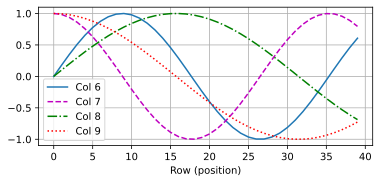

In [21]:
encoding_dim, num_steps = 32, 40
pos_encoding = PositionalEncoding(encoding_dim, 0, max_len=50)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])


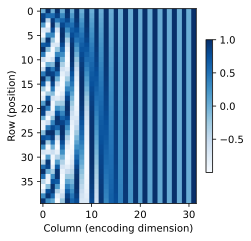

In [22]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')


# Section 11.7: Transformer Architecture

In [23]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


In [24]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)
        
    def forward(self, X):
        # Shape of input X: (batch size, sequence length in tokens, number of hidden units or feature dimension)
        return self.dense2(self.relu(self.dense1(X)))
    
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]


tensor([[ 0.4677, -0.0604, -0.1456, -0.8829, -0.6756, -0.2731, -0.6499,  0.6161],
        [ 0.4677, -0.0604, -0.1456, -0.8829, -0.6756, -0.2731, -0.6499,  0.6161],
        [ 0.4677, -0.0604, -0.1456, -0.8829, -0.6756, -0.2731, -0.6499,  0.6161]],
       grad_fn=<SelectBackward0>)

Intermezzo: Chapter 8.5: Batch normalization

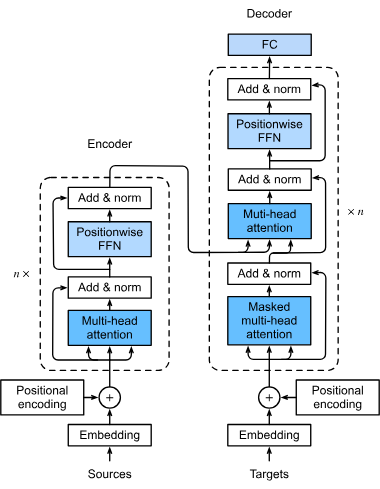

In [25]:
class AddNorm(nn.Module):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        # Seq + Pos embedding = 
        #  X => Q, K, V (multi-head attention) = Y: concat heads per position
        #  X => Residual layer
        return self.ln(self.dropout(Y) + X)


## Encoder | Decoder

In [26]:
class TransformerEncoderBlock(nn.Module):
    
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        
        # Inherits from d2l.Module
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(num_hiddens, dropout)
        self.ffn = d2l.PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(num_hiddens, dropout)
        
    def forward(self, X, valid_lens):
        # X: batch_size, seq_len, encoding_dim
        # What goes into attention:
        Y = self.addnorm1(X, self.attention(queries=X, keys=X, values=X, valid_lens=valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
    


In [27]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])

encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)

encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)


In [28]:
class TransformerEncoder(d2l.TransformerEncoderBlock):
    
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, use_bias=False, **kwargs):
        super().__init__(num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias)
        
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        
        self.blks = nn.Sequential()        
        for i in range(num_blks):
            self.blks.add_module(
                name="block"+str(i),
                module=TransformerEncoderBlock(
                    num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias
                )
            )
            
    def forward(self, X, valid_lens):
        # X = [batch_size, seq_len]
        print(f'  TransformerEncoder input X.shape: {X.shape}')
        X = self.embedding(X)
        print(f'  TransformerEncoder after emb X.shape: {X.shape}')
        X = self.pos_encoding(X * math.sqrt(self.num_hiddens))
        print(f'  TransformerEncoder after pos enc X.shape: {X.shape}')
        self.attention_weights = [None] * len(self.blks)
        
        for i, blk in enumerate(self.blks):
            
            X = blk(X, valid_lens)
            print(f'  TransformerEncoder after attention X.shape: {X.shape}')
            self.attention_weights[i] = blk.attention.attention.attention_weights
        
        # X = [batch_size, seq_len, embed_dim]
        return X
            

In [29]:
encoder = TransformerEncoder(vocab_size=200, num_hiddens=24, ffn_num_hiddens=48, num_heads=8, num_blks=2, dropout=0.5)

batch_size = 2
seq_len = 100
X = torch.ones((batch_size, seq_len), dtype=torch.long)
d2l.check_shape(encoder(X, valid_lens), (2, 100, 24))




  TransformerEncoder input X.shape: torch.Size([2, 100])
  TransformerEncoder after emb X.shape: torch.Size([2, 100, 24])
  TransformerEncoder after pos enc X.shape: torch.Size([2, 100, 24])
  TransformerEncoder after attention X.shape: torch.Size([2, 100, 24])
  TransformerEncoder after attention X.shape: torch.Size([2, 100, 24])


In [30]:
# Decoder

class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)
        
    

    def forward(self, X, state):
        # What is in X
        # What is in state? state = [attention_outputs_from_encoder, valid_lens, [None]]
        enc_outputs, enc_valid_lens = state[0], state[1]        
        
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. 
        #
        # When decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        
        if state[2][self.i] is None:  # During training
            key_values = X
        else:  # During prediction
            key_values = torch.cat((state[2][self.i], X), dim=1)
            
        state[2][self.i] = key_values    
        
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
            
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
    


In [31]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


In [32]:
embed_dim = 24

decoder_blk = TransformerDecoderBlock(num_hiddens=embed_dim, ffn_num_hiddens=48, num_heads=8, dropout=0.5, i=0)
bs = 2
seq_len = 100


# Input sequence (already embedded)
#   Embedding happens in the TransformerEncoder. Here (next line), we only use one block.
X = torch.ones((bs, seq_len, embed_dim))

attention_output = encoder_blk(X, valid_lens)
initial_state2 = [None]  # If there were more than one block, let's say 3, it would be [None, None, None]
state = [attention_output, valid_lens, [None]]

d2l.check_shape(decoder_blk(X, state)[0], X.shape)




In [33]:
# nn.Module < d2l.Decoder < d2l.AttentionDecoder < d2l.TransformerDecoder

class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


#### Original code - just to be sure

In [34]:
# d2l.Module has a method loss() [not implented]
# d2l.Module.Classifier defines CrossEntropyLoss
# d2l.Module.MultiHeadAttention does _not_ define a loss

#    nn.Module.d2l.Encoder.TransformerEncoder
#    nn.Module.d2l.Decoder.AttentionDecoder.TransformerDecoder


In [35]:
class PositionWiseFFN(nn.Module):  #@save
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


In [36]:
class AddNorm(nn.Module):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)


In [37]:
class TransformerEncoderBlock(nn.Module):  #@save
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))


In [38]:
class TransformerEncoder(d2l.Encoder):  #@save
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X


In [39]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


In [40]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


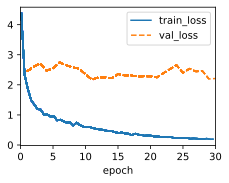

In [41]:
data = MTFraEng(batch_size=128, root='~/data_obsolete')
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)

model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


In [42]:
# How does the trainer work?
#  Loss function
#    Module.d2l.Encoder.TransformerEncoder
#    Module.d2l.Decoder.AttentionDecoder.TransformerDecoder



#  How is full target sequence used?
#    




In [43]:
def predict_step_view(self, batch, device, num_steps, save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        
        # Encode stuff
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)  # Context vectors
        
        # Decode stuff
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        
        
        # Only the first token of the target sequence is used.
        outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
        
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(Y.argmax(2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights


In [44]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


## 11.8 - Transformers for vision

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


In [92]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        print(f'img_size: {img_size}, patch_size: {patch_size}')
        
        # Number of patches
        img_height = img_size[0]
        img_width = img_size[1]
        patch_height = patch_size[0]
        patch_width = patch_size[1]
        self.num_patches = (img_height // patch_height) * (img_width // patch_width)
        
        # Single convolution operation to extract patches and then 
        # linearly projects them to verctors of length num_hiddens.
        #   out_channels, kernel_size, stride=1,
        self.conv = nn.LazyConv2d(out_channels=num_hiddens, kernel_size=patch_size, stride=patch_size)


    def forward(self, X):
        
        tmp = self.conv(X) # Shape: (batch_size, num_hiddens, num_patches_height, num_patches_width)
        #print(f'  PatchEmbedding after conv tmp.shape: {tmp.shape}')
        
        tmp = tmp.flatten(start_dim=2, end_dim=-1)  # Shape: (batch_size, num_hiddens, num_patches)
        #print(f'  PatchEmbedding after flatten tmp.shape: {tmp.shape}')
        
        return self.conv(X).flatten(start_dim=2, end_dim=-1).permute(0, 2, 1)  # (batch_size, num_patches, num_hiddens)
        

In [ ]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)

Y = patch_emb(X)


img_size: (96, 96), patch_size: (16, 16)


In [ ]:
# FNN: Original transformer
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


In [ ]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        
        self.dense1 = nn.LazyLinear(out_features=mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(out_features=mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout) 
        

    def forward(self, X):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(self.dense1(X)))))


<img src="https://d2l.ai/_images/vit.svg" width="700" height="500" />


In [96]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        # Create Q, K, V from X:
        qkv = [self.ln1(X), self.ln1(X), self.ln1(X)]
        qkv_check = [self.ln1(X)] * 3
        
        X = X + self.attention(*qkv, valid_lens)
        X = X + self.mlp(self.ln2(X))
        return X
        

In [ ]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()

Y = encoder_blk(X)
d2l.check_shape(Y, X.shape)


In [ ]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, num_hiddens)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
            
        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        
        # This line performs token concatenation, specifically prepending the learnable class token ($\text{CLS}$ token) to the 
        # sequence of image patch embeddings in the Vision Transformer (ViT) model.
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        
        # Combine token embedding with positional encoding
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
            
        # Extract the class token and pass it through the classification head
        return self.head(X[:, 0])


In [ ]:
from torchvision import transforms
import torchvision

class FashionMNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28), root='~/data_obsolete'):
        super().__init__(root=root)

        # Section 3.3.1: That function saves hyperparameters by using the Python built-in module inspect to programmatically 
        # look up the arguments and local variables of the function that called save_hyperparameters.
        # The primary purpose of that save_hyperparameters pattern is indeed to automatically track and assign the configuration 
        # arguments (the hyperparameters) that are passed into a class's __init__ method.
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

@d2l.add_to_class(FashionMNIST)  #@save
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]
    

data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)


(60000, 10000)

In [ ]:
save = False

img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout, lr)

if save:
    trainer = d2l.Trainer(max_epochs=1, num_gpus=1)
    data = FashionMNIST(batch_size=128, resize=(img_size, img_size), root='~/data_obsolete')
    trainer.fit(model, data)
    torch.save(model.state_dict(), '~/data_obsolete/vit-fmnist.params')
else:
    model.load_state_dict(torch.load('~/data_obsolete/vit-fmnist.params', weights_only=True))
    model.eval()


img_size: (96, 96), patch_size: (16, 16)


/home/calvin/.venvs/venv_d2l/lib64/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/calvin/.venvs/venv_d2l/lib64/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


```
def predict_step_view(self, batch, device, num_steps, save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        
        # Encode stuff
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)  # Context vectors
        
        # Decode stuff
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        
        
        # Only the first token of the target sequence is used.
        outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
        
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(Y.argmax(2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights

```

In [122]:
# Get some pictures for prediction
X, y = next(iter(data.train_dataloader()))

labels = model(X)

print(X.shape)
labels[0]


torch.Size([128, 1, 96, 96])


tensor([-1.7208, -4.8691, -4.5516, -0.9860, -4.5668,  3.8227, -2.4209,  3.2520,
         2.7201,  8.0793], grad_fn=<SelectBackward0>)